In [1]:
import numpy as np
import tensorflow as tf
import pickle
import string
import json
import os

from keras.models import load_model
from keras.layers import TextVectorization

model = load_model('final.h5')
from_disk = pickle.load(open("vectorconfig.pkl", "rb"))
vectoriser = TextVectorization.from_config(from_disk['config'])

vectoriser.adapt(tf.data.Dataset.from_tensor_slices(["xyz"])) # call adapt on dummy data
vectoriser.set_weights(from_disk['weights'])

from_disk = pickle.load(open("storeconfig.pkl", "rb"))
store_vectoriser = TextVectorization.from_config(from_disk['config'])

store_vectoriser.adapt(tf.data.Dataset.from_tensor_slices(["xyz"])) # call adapt on dummy data
store_vectoriser.set_weights(from_disk['weights'])

encoder = pickle.load(open("encoder.pickle", "rb"))

In [2]:
folder_path = 'receipts'

items = []
stores = []

for file in os.listdir(folder_path):
    receipt_path = os.path.join(folder_path, file)

    with open(receipt_path) as receipt_data:
        receipt = json.load(receipt_data)

    item_list = receipt['itemList'] + receipt['discountList']

    for item in item_list:
        items.append([item['itemName']])
        stores.append([receipt['storeName']])

In [3]:
def lower(product):
    text = product[0]
    result = " ".join([word.lower() for word in text.split()])
    return [result]

def remove_punc_nums(product):
    text = product[0]
    remove = str.maketrans((string.punctuation + '£' + string.digits), ' '*len((string.punctuation + '£' + string.digits)))
    return [text.translate(remove)]


In [4]:
items = list(map(lower, items))
items = list(map(remove_punc_nums, items))
items = list(map(lower, items))

In [7]:
product_string = tf.keras.Input(shape=(1,), dtype="string")
store_string = tf.keras.Input(shape=(1,), dtype="string")

x = vectoriser(product_string)
x2 = store_vectoriser(store_string)

class_names= encoder.classes_

predictions = model([x, x2])


e2e_model = tf.keras.Model([product_string, store_string], predictions)

products_input = tf.convert_to_tensor(items)
store_input = tf.convert_to_tensor(stores)

categories = {}

probabilities = e2e_model.predict([products_input, store_input])

for i in tf.range(len(probabilities)):
    if float('{0:.2f}'.format(np.max(probabilities[i]))) <0.5:
        print("\nBELOW 0.5 CONF")
        print(""+products_input.numpy()[i][0].decode('UTF-8') + ", " + store_input.numpy()[i][0].decode('UTF-8'))
        print("(" + class_names[np.argmax(probabilities[i])] + ": " + str(float('{0:.3f}'.format(np.max(probabilities[i])))) + ")\n")
    else:
        print(products_input.numpy()[i][0].decode('UTF-8') + ", " + store_input.numpy()[i][0].decode('UTF-8') + "\n(" + class_names[np.argmax(probabilities[i])] + ": " + str(float('{0:.3f}'.format(np.max(probabilities[i])))) + " conf)")
        try:
            categories[class_names[np.argmax(probabilities[i])]] += 1
        except:
            categories[class_names[np.argmax(probabilities[i])]] = 1

tesco grlc g, TESCO
(groceries: 1.0 conf)
yogurt, TESCO
(groceries: 1.0 conf)
tesco grlc g, TESCO
(groceries: 1.0 conf)
chicken drums, TESCO
(groceries: 1.0 conf)
f range eggs, TESCO
(groceries: 1.0 conf)
mullcdrspice, TESCO
(groceries: 1.0 conf)
dried yeast, TESCO
(groceries: 0.991 conf)
potatoes, TESCO
(groceries: 1.0 conf)
pork slices, TESCO
(groceries: 1.0 conf)
cafe latte, TESCO
(drinks: 1.0 conf)
cafe latte, TESCO
(drinks: 1.0 conf)
cafe latte, TESCO
(drinks: 1.0 conf)
cafe latte, TESCO
(drinks: 1.0 conf)
w g dan wht, TESCO
(groceries: 1.0 conf)
bread, TESCO
(groceries: 1.0 conf)
lamb chops, TESCO
(groceries: 1.0 conf)
lamb chops, TESCO
(groceries: 1.0 conf)
cc lamb chops, TESCO
(groceries: 1.0 conf)
cc lamb chops, TESCO
(groceries: 1.0 conf)


In [15]:
list(categories.values())

[15, 4]

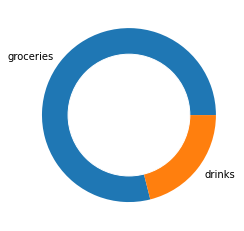

In [18]:
import matplotlib.pyplot as plt

# create data
names = list(categories.keys())
size_of_groups=list(categories.values())

# Create a pieplot
plt.pie(size_of_groups, labels=names)

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.show()

In [9]:
categories

{'groceries': 15, 'drinks': 4}